## How did Brexit impact exchange rates between the British Pound and US Dollar?

In [40]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt 
from scipy import stats
import datetime

In [41]:
# data prior to the event 
PRE_PERIOD=[pd.to_datetime('2012-01-03'), pd.to_datetime('2016-06-23')]

# Duration of period after the event to analyze
POST_PERIOD_LENGTH=28
POST_PERIOD=[pd.to_datetime('2016-06-24'), pd.to_datetime('2016-7-22')]

CONTEXT_WINDOW = 1 * POST_PERIOD_LENGTH

In [42]:
SCENARIO = 'exchange-rates'
TRAIN_CSV = 'train.csv'
FORECAST_INPUT_CSV = 'forecast_input.csv'

Dataset from FRED(Federal Reserve Economic Data)

In [43]:
def read_fred_data(dataset, start_date, end_date):
    url = f'https://fred.stlouisfed.org/graph/fredgraph.csv?id={dataset}&cosd={str(start_date)[:10]}&coed={str(end_date)[:10]}'
    return pd.read_csv(url, index_col='DATE', parse_dates=True, na_values='.')

In [44]:
# history of USD and British Pound
df_DEXUSUK=read_fred_data('DEXUSUK', PRE_PERIOD[0], POST_PERIOD[1])

# history of USD and Euro
df_DEXUSEU=read_fred_data('DEXUSEU', PRE_PERIOD[0], POST_PERIOD[1])

### EDA

In [45]:
df_DEXUSUK.head()

,DEXUSUK
DATE,
2012-01-03,1.5655
2012-01-04,1.5638
2012-01-05,1.5480
2012-01-06,1.5431
2012-01-09,1.5436


In [46]:
df_DEXUSEU.head()

,DEXUSEU
DATE,
2012-01-03,1.3061
2012-01-04,1.2930
2012-01-05,1.2783
2012-01-06,1.2723
2012-01-09,1.2745


In [47]:
df = pd.merge(left=df_DEXUSEU, left_on=df_DEXUSEU.index, right=df_DEXUSUK, right_on=df_DEXUSUK.index).rename(columns={'key_0':'DATE'}).set_index('DATE').dropna()

df.head()

,DEXUSEU,DEXUSUK
DATE,,
2012-01-03,1.3061,1.5655
2012-01-04,1.2930,1.5638
2012-01-05,1.2783,1.5480
2012-01-06,1.2723,1.5431
2012-01-09,1.2745,1.5436


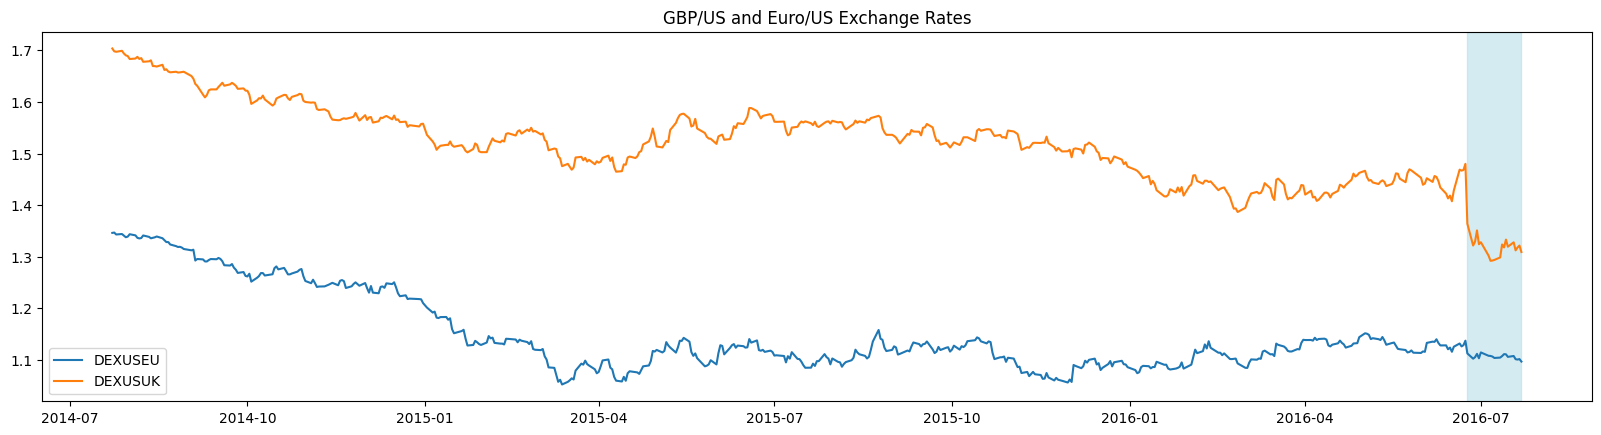

In [48]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.plot(df[POST_PERIOD[1] - datetime.timedelta(days=730):POST_PERIOD[1]])
ax.axvspan(POST_PERIOD[0], POST_PERIOD[1], alpha=0.5, color='lightblue')

plt.title('GBP/US and Euro/US Exchange Rates')
plt.legend(df.columns)
plt.show()

In [49]:
corr, _ = stats.pearsonr(x=df.DEXUSEU[df.index <= PRE_PERIOD[1]], y=df.DEXUSUK[df.index <= PRE_PERIOD[1]])

print(f'Pearson correlation between time series in the pre-period: {round(corr, 2)}')

Pearson correlation between time series in the pre-period: 0.76


D:\After\torch\Lib\site-packages\causalimpact\misc.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mu = data_mu[0]
D:\After\torch\Lib\site-packages\causalimpact\misc.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sd = data_sd[0]
D:\After\torch\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                                Average       Cumulative
Actual                                1               26
Predicted                             1               29
95% CI                           [1, 1]         [28, 29]
                                                        
Absolute Effect                       0               -2
95% CI                           [0, 0]         [-2, -3]
                                                        
Relative Effect                   -9.7%            -9.7%
95% CI                  [-7.2%, -12.2%]  [-7.2%, -12.2%]
                                                        
P-value                            0.0%                 
Prob. of Causal Effect           100.0%                 
None


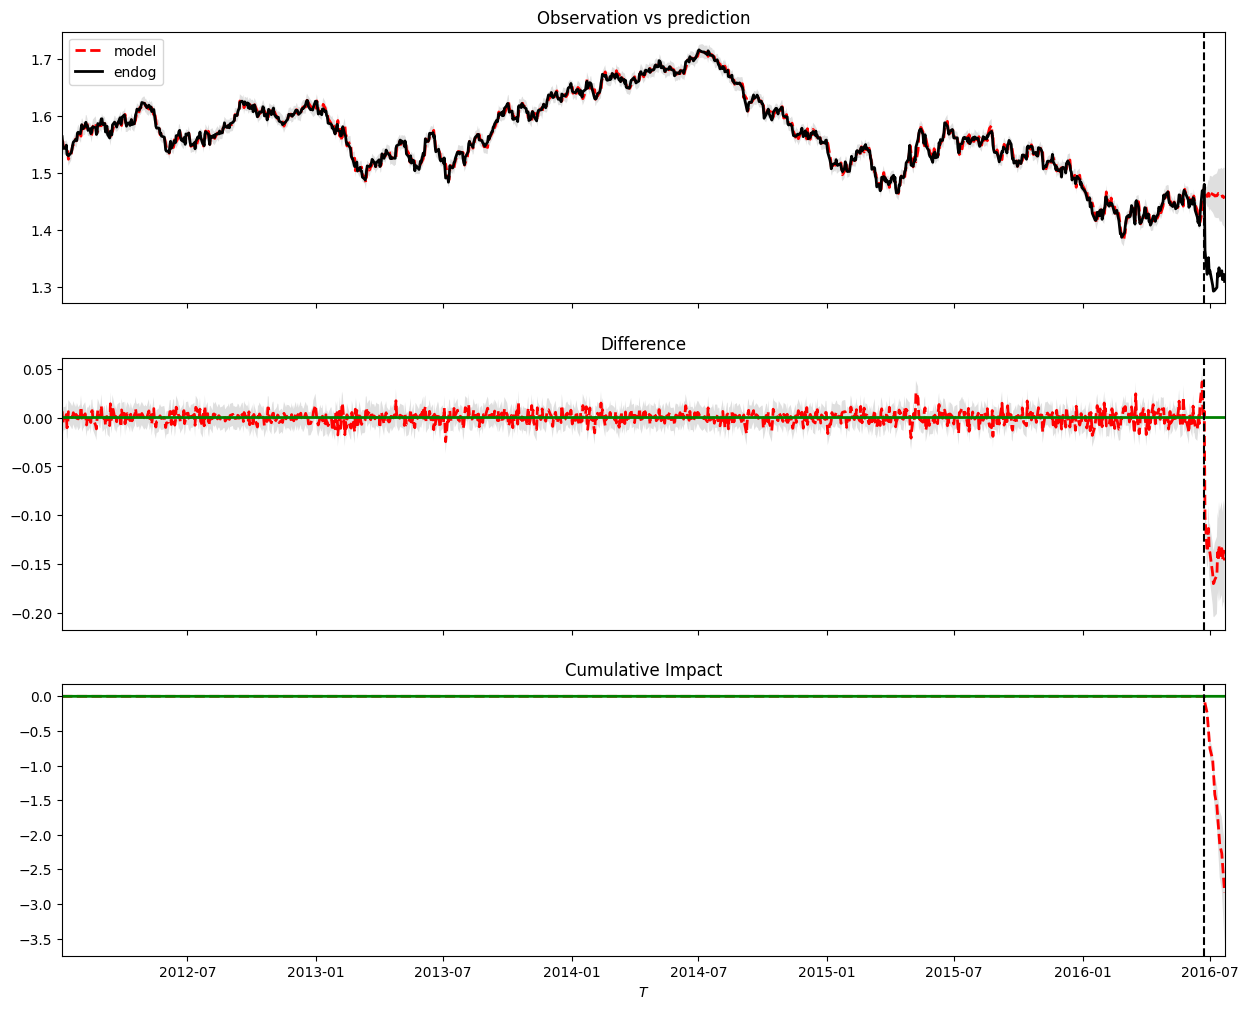

In [50]:
from causalimpact import CausalImpact

PRE_PERIOD2=[pd.to_datetime('2014-01-03'), pd.to_datetime('2016-06-23')]
POST_PERIOD2=[pd.to_datetime('2016-06-24'), pd.to_datetime('2016-7-22')]

ci = CausalImpact(df[['DEXUSUK', 'DEXUSEU']], PRE_PERIOD, POST_PERIOD)
ci.run()
print(ci.summary())
# print(ci.summary(output='report'))
ci.plot()

In [51]:
# ci = CausalImpact(df[['DEXUSUK', 'DEXUSEU']], PRE_PERIOD, POST_PERIOD)

# # Run the analysis
# ci.run()

# # Print summary
# print(ci.summary())
# print(ci.summary(output='report'))

# # Plot the results
# fig, ax = plt.subplots(figsize=(12, 6))  # Increase the figure size for better visibility
# ci.plot(ax)

# # Optionally, adjust the x-axis limits to make sure the post-period is visible
# # Set the x-axis to show the entire range of the data
# ax.set_xlim(df.index.min(), df.index.max())

# # Adjust other plot properties if needed
# ax.set_title("Causal Impact Analysis", fontsize=16)
# plt.tight_layout()  # Ensure everything fits properly
# plt.show()

In [52]:
# training data 
df_train = df[df.index <= PRE_PERIOD[1]].copy()
df_train['ID'] = 0  # Assign a single series ID
df_train.to_csv('train_data.csv')  # Save locally

df_train.head()

,DEXUSEU,DEXUSUK,ID
DATE,,,
2012-01-03,1.3061,1.5655,0
2012-01-04,1.2930,1.5638,0
2012-01-05,1.2783,1.5480,0
2012-01-06,1.2723,1.5431,0
2012-01-09,1.2745,1.5436,0


In [53]:
# Create a forecast input DataFrame
df_forecast_input = df.copy()
df_forecast_input['ID'] = 0
df_forecast_input.loc[df_forecast_input.index >= POST_PERIOD[0], 'DEXUSUK'] = np.NaN  # Blank future values
df_forecast_input.to_csv('forecast_input.csv')  # Save locally

df_forecast_input.head()


,DEXUSEU,DEXUSUK,ID
DATE,,,
2012-01-03,1.3061,1.5655,0
2012-01-04,1.2930,1.5638,0
2012-01-05,1.2783,1.5480,0
2012-01-06,1.2723,1.5431,0
2012-01-09,1.2745,1.5436,0


In [ ]:
!pip install prophet

In [55]:
from causalimpact import CausalImpact

In [56]:
print(df.loc[PRE_PERIOD[0]:PRE_PERIOD[1], ['DEXUSUK', 'DEXUSEU']].shape)
print(df.loc[POST_PERIOD[0]:POST_PERIOD[1], ['DEXUSUK', 'DEXUSEU']].shape)

(1124, 2)
(20, 2)


In [57]:
print("Missing values before handling:")
print(df.isna().sum())

Missing values before handling:
DEXUSEU    0
DEXUSUK    0
dtype: int64


## Prophet Model (Without any regressor)

Without any regressor, it solely focuses on the historical behaviour of the target variable (y), and model its components. Its components are:
1. Trend : models the non-periodic changes over time
2. Seasonality : models periodic changes (e.g., daily, weekly, yearly).
3. Holidat/events : captures impacts of known events.

$y(t)=g(t)+s(t)+h(t)+\epsilon_t$

In [58]:
from prophet import Prophet

# dataset
df_prophet = df_train.reset_index()[['DATE', 'DEXUSUK']]
df_prophet.columns = ['ds', 'y']  # column names

# Train 
model = Prophet()
model.fit(df_prophet)

# Forecasting
future = model.make_future_dataframe(periods=POST_PERIOD_LENGTH)
forecast = model.predict(future)

#predictions
forecast_df = forecast[['ds', 'yhat']].set_index('ds')
forecast_df.columns = ['predicted_DEXUSUK']
forecast_df.head()


18:13:52 - cmdstanpy - INFO - Chain [1] start processing
18:13:52 - cmdstanpy - INFO - Chain [1] done processing


,predicted_DEXUSUK
ds,
2012-01-03,1.556367
2012-01-04,1.556157
2012-01-05,1.556227
2012-01-06,1.554642
2012-01-09,1.554280


In [59]:
# Merge actual and predicted values
df_forecast_output = forecast_df  # forecast output
df_estimate = df[['DEXUSUK']].merge(df_forecast_output, left_index=True, right_index=True, how='left')

# Fill missing values with predictions
df_counterfactual = df_estimate.copy()
df_counterfactual.loc[df_estimate.index.isin(df_forecast_output.index), 'predicted_DEXUSUK'] = forecast_df['predicted_DEXUSUK']
df_estimate = pd.merge(df_estimate, df_counterfactual, on='DATE', suffixes=('', '_counterfactual'))

df_estimate.head()


,DEXUSUK,predicted_DEXUSUK,DEXUSUK_counterfactual,predicted_DEXUSUK_counterfactual
DATE,,,,
2012-01-03,1.5655,1.556367,1.5655,1.556367
2012-01-04,1.5638,1.556157,1.5638,1.556157
2012-01-05,1.5480,1.556227,1.5480,1.556227
2012-01-06,1.5431,1.554642,1.5431,1.554642
2012-01-09,1.5436,1.554280,1.5436,1.554280


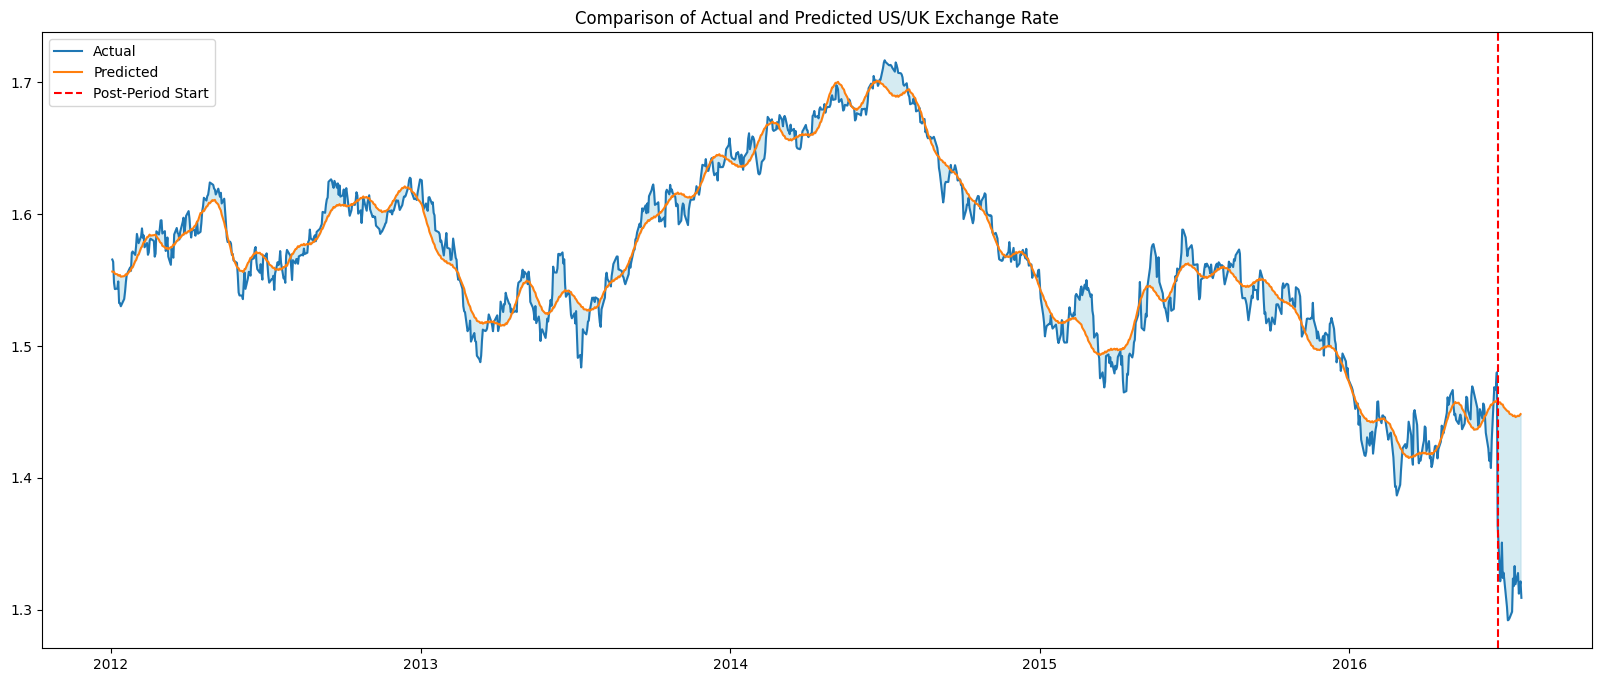

Actual US/UK exchange rate:    1.319
Predicted US/UK exchange rate: 1.451
Average treatment effect:     -0.124
Relative treatment effect:    -8.58%


In [60]:
# Plot actual vs. predicted
post_period_start = datetime.datetime(2016, 6, 24)
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df_estimate.index, df_estimate['DEXUSUK'], label='Actual')
ax.plot(df_estimate.index, df_estimate['predicted_DEXUSUK'], label='Predicted')
ax.fill_between(df_estimate.index, df_estimate['DEXUSUK'], df_estimate['predicted_DEXUSUK'], color='lightblue', alpha=0.5)
ax.axvline(x=post_period_start, color='red', linestyle='--', label='Post-Period Start')
plt.title('Comparison of Actual and Predicted US/UK Exchange Rate')
plt.legend()
plt.show()

# Metrics
df_post_period = df_estimate[df_estimate.index >= POST_PERIOD[0]]
mean_actual = df_post_period['DEXUSUK'].mean()
mean_predicted = df_post_period['predicted_DEXUSUK'].mean()

auc = (df_post_period['DEXUSUK'] - df_post_period['predicted_DEXUSUK']).sum()
ate = auc / len(df_post_period.index)

print(f'Actual US/UK exchange rate:    {round(mean_actual, 3)}')
print(f'Predicted US/UK exchange rate: {round(mean_predicted, 3)}')
print(f'Average treatment effect:     {round(ate, 3)}')
print(f'Relative treatment effect:    {round(ate / mean_predicted * 100, 3)}%')


Exchange Rate decreased by 0.124, i.e. 8.58% than if Brexit had not occurred.

## Prophet Model (With regressor)

With regressor, it extends the additive model to include exogenous variables, and model its components. Regressors allow the model to incorporate information beyond the target variable's history, improving forecasts when external variables correlate strongly with the target.

$y(t)=g(t)+s(t)+h(t)+\beta_1x_1(t) +\beta_2x_2(t)+ ... + \epsilon_t$

where, \
$x_i(t): External\ regressor\ i\ at\ time t$ \
$\beta_i: Coefficient\ capturing\ impact\ of\ x_i(t)\ on\ y(t)$

In [33]:
# Merge on index
df = pd.merge(df_DEXUSUK, df_DEXUSEU, left_index=True, right_index=True, suffixes=('_UK', '_EU'))
df = df.dropna().reset_index().rename(columns={'index': 'DATE'})

df_train = df[df['DATE'] <= PRE_PERIOD[1]].copy()
df_train_prophet = df_train[['DATE', 'DEXUSUK', 'DEXUSEU']].rename(columns={'DATE': 'ds', 'DEXUSUK': 'y'})

# Add regressor
model = Prophet()
model.add_regressor('DEXUSEU')

model.fit(df_train_prophet)

# fill `DEXUSEU` (post-period)
df_forecast_input = df[['DATE', 'DEXUSUK', 'DEXUSEU']].rename(columns={'DATE': 'ds', 'DEXUSUK': 'y'})
df_forecast_input.loc[df_forecast_input['ds'] >= POST_PERIOD[0], 'y'] = np.NaN  # post-period

# Extend the future dataframe
future = model.make_future_dataframe(periods=POST_PERIOD_LENGTH, freq='D')
future = future.merge(df_forecast_input[['ds', 'DEXUSEU']], on='ds', how='left')

# Fill missing `DEXUSEU` (use the last known value)
future['DEXUSEU'].fillna(method='ffill', inplace=True)

forecast = model.predict(future)
forecast_df = forecast[['ds', 'yhat']].set_index('ds')
forecast_df.columns = ['predicted_DEXUSUK']

# Merge actual and predicted 
df_estimate = df.set_index('DATE')[['DEXUSUK']].merge(forecast_df, left_index=True, right_index=True, how='left')

# Fill missing predicted values in the post-period
df_counterfactual = df_estimate.copy()
df_counterfactual['predicted_DEXUSUK'] = df_counterfactual['predicted_DEXUSUK'].fillna(forecast_df['predicted_DEXUSUK'])

17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3032\1171973612.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future['DEXUSEU'].fillna(method='ffill', inplace=True)
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3032\1171973612.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['DEXUSEU'].fillna(method='ffill', inplace=Tr

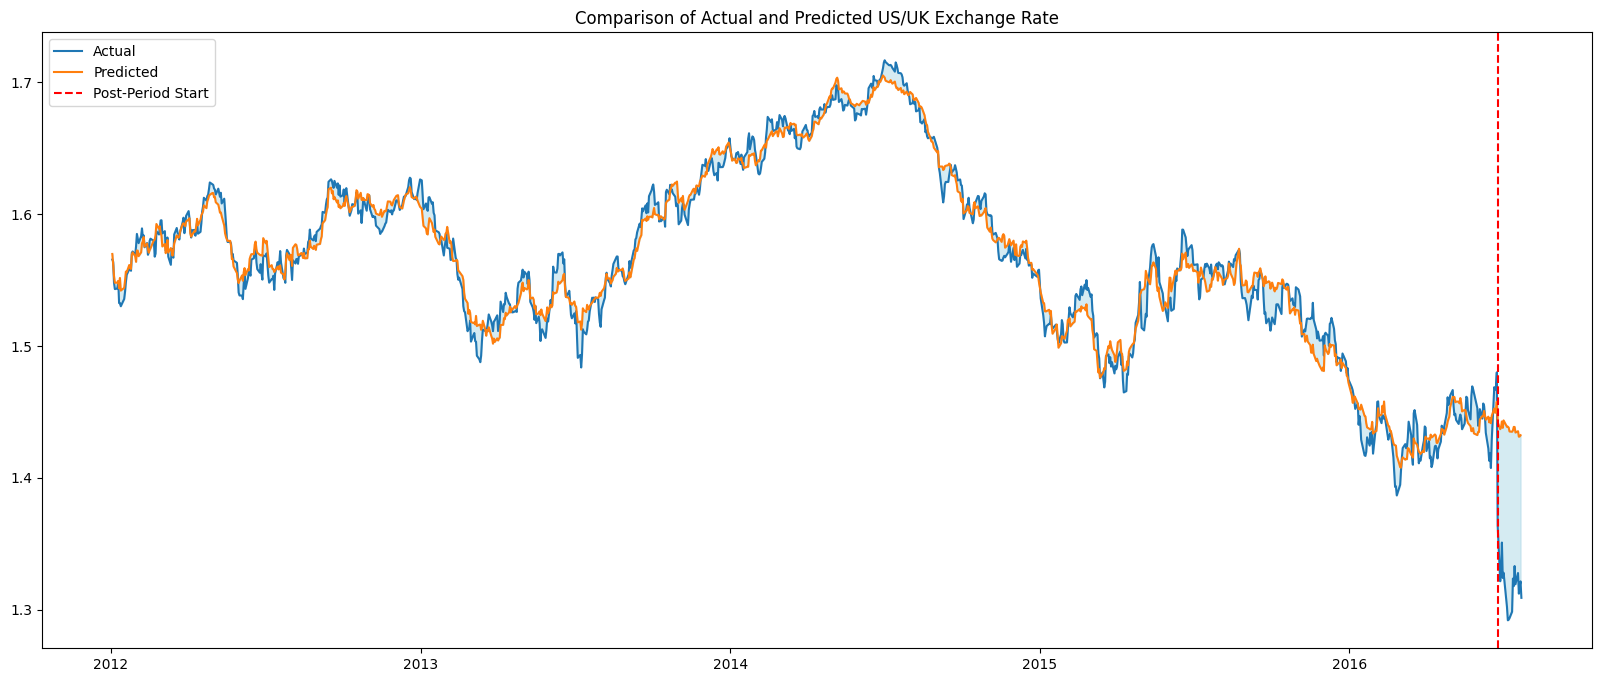

Actual US/UK exchange rate:    1.319
Predicted US/UK exchange rate: 1.437
Average treatment effect:     -0.112
Relative treatment effect:    -7.773%


In [39]:
# Plot actual vs. predicted
post_period_start = datetime.datetime(2016, 6, 24)
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df_estimate.index, df_estimate['DEXUSUK'], label='Actual')
ax.plot(df_estimate.index, df_estimate['predicted_DEXUSUK'], label='Predicted')
ax.fill_between(df_estimate.index, df_estimate['DEXUSUK'], df_estimate['predicted_DEXUSUK'], color='lightblue', alpha=0.5)
ax.axvline(x=post_period_start, color='red', linestyle='--', label='Post-Period Start')
plt.title('Comparison of Actual and Predicted US/UK Exchange Rate')
plt.legend()
plt.show()

# Post-period analysis
df_post_period = df_estimate[df_estimate.index >= POST_PERIOD[0]]

mean_actual = df_post_period['DEXUSUK'].mean()
mean_predicted = df_post_period['predicted_DEXUSUK'].mean()

# Calculate metrics
auc = (df_post_period['DEXUSUK'] - df_post_period['predicted_DEXUSUK']).sum()
ate = auc / len(df_post_period.index)

print(f'Actual US/UK exchange rate:    {round(mean_actual, 3)}')
print(f'Predicted US/UK exchange rate: {round(mean_predicted, 3)}')
print(f'Average treatment effect:     {round(ate, 3)}')
print(f'Relative treatment effect:    {round(ate / mean_predicted * 100, 3)}%')

Exchange Rate decreased by 0.112, i.e. 7.77% than if Brexit had not occurred.